PPG-DaLiA contains data from 15 subjects wearing physiological and motion sensors, providing a PPG dataset for motion compensation and heart rate estimation in Daily Life Activities

In [1]:
import joblib
import requests
import os
from pathlib import Path
from os.path import expanduser
import pandas as pd
import numpy as np
import pickle
import re
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

DIRECTORY WHERE IS LOCATED THE DATASET

In [2]:
home = os.getcwd()
PPG_dir = os.path.join(home, "PPG-DaLiA")

In [3]:
os.chdir(PPG_dir)

In [4]:
os.getcwd()

'C:\\Users\\Admin\\PPG-DaLiA\\Jupyter code\\PPG-DaLiA'

GET ALL DATAS FROM SUBJECTS

In [5]:
subjects_datas = {}
subject_files = os.listdir("./PPG_FieldStudy")

for i in range(1,16):
    subjects_datas[i] = pd.read_pickle(f"./PPG_FieldStudy/S{i}/S{i}.pkl")

Mettre toutes les mesures à la même échelle : 4 Hz

Activity : 4 Hz | Signal Chest à 700 Hz | Signal Wrist : ACC = 32 Hz, BVP : 64 Hz

In [6]:
def scaling_mesures(mesures, frequence):
    scale_to_4_hz = []
    number_mesures_for_scaling = int(frequence / 4)
    
    for i in range(0, len(mesures), number_mesures_for_scaling):
        somme_echelle_4_hz = sum(mesures[i:i+number_mesures_for_scaling]) / number_mesures_for_scaling
        scale_to_4_hz.append(somme_echelle_4_hz)
    return scale_to_4_hz

In [7]:
def get_subject_dataframe(subject):
    # delete dummy datas
    del subject['signal']['chest']['EDA']
    del subject['signal']['chest']['EMG']
    del subject['signal']['chest']['Temp']
    del subject['signal']['wrist']['EDA']
    
    # Chest ACC : from 700 Hz to 4 Hz
    ACC_chest_ACC = subject["signal"]["chest"]["ACC"]
    subject["signal"]["chest"]["ACC"] = scaling_mesures(ACC_chest_ACC, 700)
    
    # Chest ECG : from 700 Hz to 4 Hz
    ACC_chest_ECG = subject["signal"]["chest"]["ECG"]
    subject["signal"]["chest"]["ECG"] = scaling_mesures(ACC_chest_ECG, 700)

    # Chest Resp : from 700 Hz to 4 Hz
    ACC_chest_Resp = subject["signal"]["chest"]["Resp"]
    subject["signal"]["chest"]["Resp"] = scaling_mesures(ACC_chest_Resp, 700)

    # Wrist ACC : from 32 Hz to 4 Hz
    ACC_wrist_ACC = subject["signal"]["wrist"]["ACC"]
    subject["signal"]["wrist"]["ACC"] = scaling_mesures(ACC_wrist_ACC, 32)

    # Wrist BVP : from 64 Hz to 4 Hz
    ACC_wrist_BVP = subject["signal"]["wrist"]["BVP"]
    subject["signal"]["wrist"]["BVP"] = scaling_mesures(ACC_wrist_BVP, 64)
    
    # Le capteur mis sur le torse est utilise pour calculer l'ECG
    # mesures chest ACC
    pd_chest_ACC = pd.DataFrame.from_dict(subject["signal"]["chest"]["ACC"])
    pd_chest_ACC.rename(columns={0:'ACC_x_chest',
                         1:'ACC_y_chest',
                         2:'ACC_z_chest'}, inplace=True)

    # mesures chest ECG
    pd_chest_ECG = pd.DataFrame.from_dict(subject["signal"]["chest"]["ECG"])
    pd_chest_ECG.rename(columns={0:'ECG_chest'}, inplace=True)

    # mesures chest Resp
    pd_chest_Resp = pd.DataFrame.from_dict(subject["signal"]["chest"]["Resp"])
    pd_chest_Resp.rename(columns={0:'Resp_chest'}, inplace=True)

    # DATAFRAME MESURES CHEST
    pd_chest_ACC.reset_index(drop=True, inplace=True)
    pd_chest_ECG.reset_index(drop=True, inplace=True)
    pd_chest_Resp.reset_index(drop=True, inplace=True)

    pd_chest = pd.concat([pd_chest_ACC, pd_chest_ECG, pd_chest_Resp], axis=1)
    
    # Le capteur sur le wrist est utilisé pour calculer le PPG
    # mesures wrist ACC
    pd_wrist_ACC = pd.DataFrame.from_dict(subject["signal"]["wrist"]["ACC"])
    pd_wrist_ACC.rename(columns={0:'ACC_x_wrist', 
                                 1:'ACC_y_wrist', 
                                 2:'ACC_z_wrist'}, inplace=True)

    # mesures wrist BVP
    pd_wrist_BVP = pd.DataFrame.from_dict(subject["signal"]["wrist"]["BVP"])
    pd_wrist_BVP.rename(columns={0:'BVP_wrist'}, inplace=True)

    # mesures wrist TEMP
    pd_wrist_TEMP = pd.DataFrame.from_dict(subject["signal"]["wrist"]["TEMP"])
    pd_wrist_TEMP.rename(columns={0:'TEMP_wrist'}, inplace=True)

    # DATAFRAME MESURES WRIST
    pd_wrist_ACC.reset_index(drop=True, inplace=True)
    pd_wrist_BVP.reset_index(drop=True, inplace=True)
    pd_wrist_TEMP.reset_index(drop=True, inplace=True)

    pd_wrist = pd.concat([pd_wrist_ACC, pd_wrist_BVP, pd_wrist_TEMP], axis=1)
    
    pd_activity = pd.DataFrame.from_dict(subject["activity"])
    pd_activity.rename(columns={0:'activity'}, inplace=True)
    
    pd_questionnaire = subject["questionnaire"]
    df_info_user = pd.DataFrame.from_dict(pd_questionnaire, orient = 'index').T
    df_info_user = pd.concat([df_info_user]*len(pd_chest), ignore_index=True)
    
    subject_id = subject['subject'][1:]
    array_subject_id = [subject_id] * len(pd_chest)
    df_subject_id = pd.DataFrame(array_subject_id)
    df_subject_id.rename(columns = {0:'Subject'}, inplace=True)
    
    pd_chest.reset_index(drop=True, inplace=True)
    pd_wrist.reset_index(drop=True, inplace=True)
    pd_activity.reset_index(drop=True, inplace=True)
    df_info_user.reset_index(drop=True, inplace=True)
    df_subject_id.reset_index(drop=True, inplace=True)
    
    pd_subject = pd.concat([pd_chest, pd_wrist, pd_activity, df_info_user, df_subject_id], axis=1)
    
    df_subject_model_weight = pd_subject['WEIGHT']
    df_subject_model_height = pd_subject['HEIGHT'] / 100
    pd_subject['IMC'] = df_subject_model_weight / df_subject_model_height**2
    
    replace_values = {' m' : 1, ' f' : 0}  
    pd_subject['Gender'] = pd_subject['Gender'].map(replace_values)
    
    subject1_label = subject['label']
    subject1_label = subject1_label.repeat(len(subject['activity'])/len(subject['label'])).tolist()
    avg_heart_rate = sum(subject['label']/len(subject['label']))
    avg_heart_rate_array = [avg_heart_rate]*(len(subject['activity'])-len(subject1_label))
    subject1_label.extend(avg_heart_rate_array)
    pd_subject['label'] = subject1_label
    
    #
    
    index = 700
    nb_battement_par_seconde = []
    nb_battement = 0

    for peak in subject["rpeaks"]:
        if peak < index:
            nb_battement += 1
        else:
            nb_battement_par_seconde.append(nb_battement)
            index += 700
            nb_battement = 1
        
    subject1_rpeak = nb_battement_par_seconde
    subject1_rpeak = [peak for peak in nb_battement_par_seconde for i in range(4)]

    avg_bat_par_seconde = 1
    avg_bat_par_seconde_array = [avg_bat_par_seconde]*(len(subject['activity'])-len(subject1_rpeak))
    subject1_rpeak.extend(avg_bat_par_seconde_array)
    pd_subject['rpeaks'] = subject1_rpeak
    
    del pd_subject['HEIGHT']
    del pd_subject['WEIGHT']
    
    return pd_subject

In [8]:
for key, value in subjects_datas.items():
    subjects_datas[key] = get_subject_dataframe(value)

In [9]:
# concatenate dataframe
df_subject_model = pd.concat([subjects_datas[1], 
                              subjects_datas[2], 
                              subjects_datas[3],
                              subjects_datas[4],
                              subjects_datas[5],
                              subjects_datas[6],
                              subjects_datas[7],
                              subjects_datas[8],
                              subjects_datas[9],
                              subjects_datas[10],
                              subjects_datas[11],
                              subjects_datas[12],
                              subjects_datas[13],
                              subjects_datas[14],
                              subjects_datas[15]])
df_subject_model

,ACC_x_chest,ACC_y_chest,ACC_z_chest,ECG_chest,Resp_chest,ACC_x_wrist,ACC_y_wrist,ACC_z_wrist,BVP_wrist,TEMP_wrist,activity,Gender,AGE,SKIN,SPORT,Subject,IMC,label,rpeaks
0,0.852157,-0.066488,-0.367784,0.035650,4.834438,-0.763672,-0.076172,0.669922,0.138125,32.13,0.0,1,34,3,6,1,23.5479,49.611369,1
1,0.851262,-0.066655,-0.370442,0.103145,4.238839,-0.763672,-0.078125,0.671875,-26.262500,32.16,0.0,1,34,3,6,1,23.5479,49.611369,1
2,0.851570,-0.064677,-0.370251,0.099101,2.058559,-0.761719,-0.078125,0.671875,-40.959375,32.16,0.0,1,34,3,6,1,23.5479,49.611369,1
3,0.852142,-0.065486,-0.371278,-0.170757,-0.463981,-0.753906,-0.078125,0.671875,24.173125,32.16,0.0,1,34,3,6,1,23.5479,49.611369,1
4,0.851958,-0.065894,-0.370466,-0.036633,-1.867397,-0.761719,-0.076172,0.671875,25.781250,32.16,0.0,1,34,3,6,1,23.5479,49.611369,1
5,0.853454,-0.066655,-0.367393,0.027540,-1.400373,-0.763672,-0.078125,0.671875,8.678125,32.15,0.0,1,34,3,6,1,23.5479,49.611369,1
6,0.848446,-0.068993,-0.377715,0.119724,0.611511,-0.755859,-0.076172,0.673828,-17.215625,32.15,0.0,1,34,3,6,1,23.5479,49.611369,1
7,0.848849,-0.063319,-0.363015,0.134410,2.554940,-0.765625,-0.070312,0.671875,-35.286875,32.15,0.0,1,34,3,6,1,23.5479,49.611369,1
8,0.847730,-0.070083,-0.379448,-0.212572,2.310625,-0.751953,-0.078125,0.671875,21.870000,32.15,0.0,1,34,3,6,1,23.5479,50.323992,1
9,0.848426,-0.065433,-0.378317,-0.074286,0.124163,-0.755859,-0.078125,0.671875,28.181250,32.15,0.0,1,34,3,6,1,23.5479,50.323992,1


In [10]:
df_subject_model.describe()

,ACC_x_chest,ACC_y_chest,ACC_z_chest,ECG_chest,Resp_chest,ACC_x_wrist,ACC_y_wrist,ACC_z_wrist,BVP_wrist,TEMP_wrist,activity,Gender,label,rpeaks
count,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000,517956.000000
mean,0.864339,-0.006771,-0.101649,0.001154,0.047549,-0.523429,0.100165,0.356016,-0.000779,33.068502,3.835615,0.457498,89.429096,1.484659
std,0.118683,0.096729,0.287606,0.138406,4.353410,0.317414,0.628524,0.384451,69.907997,1.812486,2.979353,0.498191,22.822404,0.557125
min,-0.619425,-0.852113,-0.971887,-1.431613,-49.979893,-1.873047,-1.791016,-1.757812,-1422.403750,26.270000,0.000000,0.000000,41.690851,1.000000
25%,0.811350,-0.067893,-0.266579,-0.059567,-2.219084,-0.785156,-0.345703,0.115234,-25.565000,31.810000,0.000000,0.000000,73.722822,1.000000
50%,0.888661,-0.011176,-0.087678,-0.000372,-0.064732,-0.509766,-0.007812,0.339844,1.584687,33.500000,5.000000,0.000000,85.291670,1.000000
75%,0.913559,0.049992,0.085235,0.061709,2.198536,-0.296875,0.656250,0.687500,27.620781,34.340000,6.000000,1.000000,101.348951,2.000000
max,1.616426,0.790446,1.370185,1.447846,49.974470,1.322266,1.916016,1.681641,1446.062500,36.450000,8.000000,1.000000,187.015425,4.000000


In [7]:
# CORRELATIONS ENTRE VARIABLES

In [11]:
matrix_correlation = df_subject_model.corr()

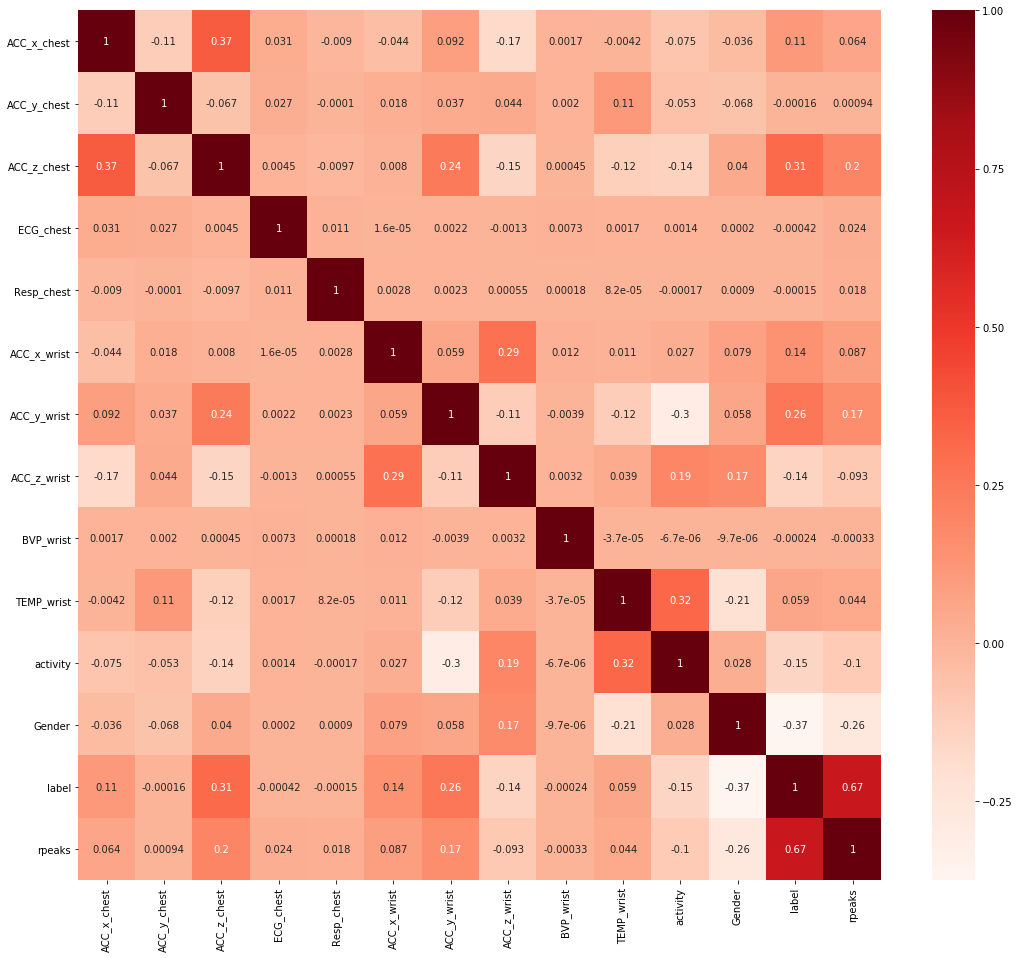

In [12]:
plt.figure(figsize=(18,16))
sn.heatmap(matrix_correlation, annot=True, cmap=plt.cm.Reds)
plt.show()

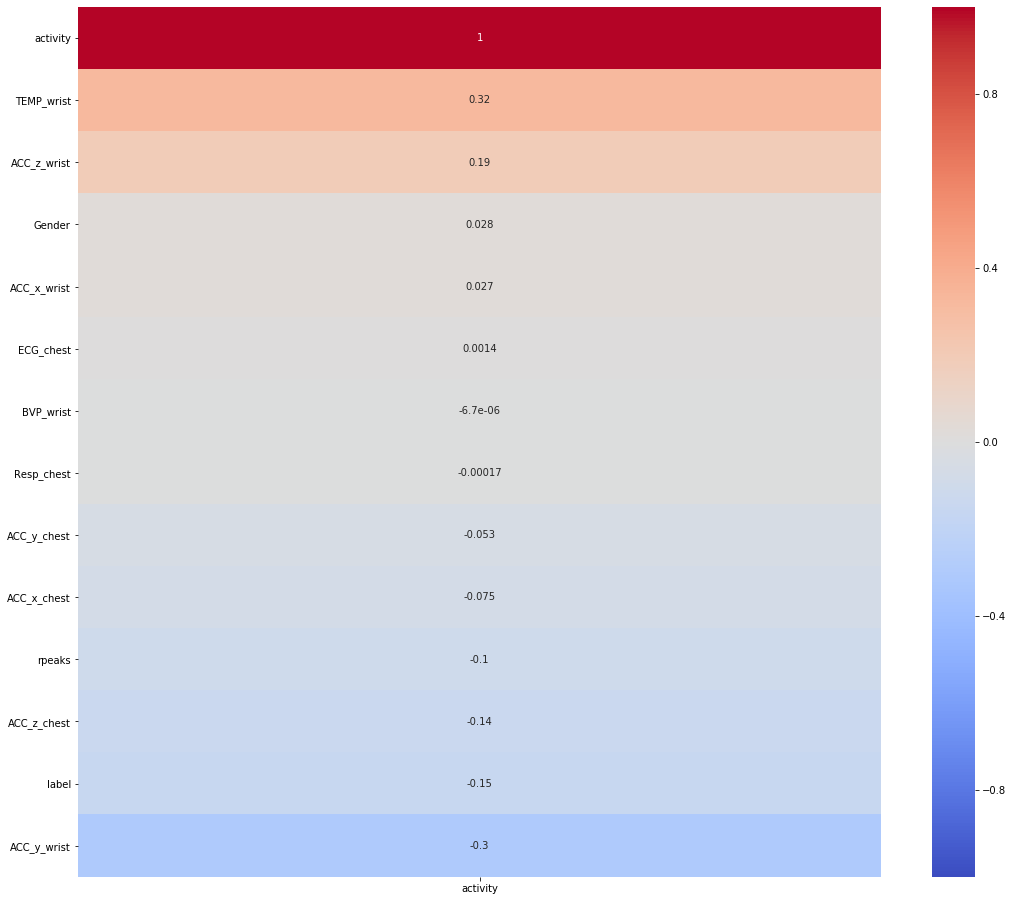

In [13]:
plt.figure(figsize=(18,16))
sn.heatmap(matrix_correlation[['activity']].sort_values(by=['activity'], ascending=False), 
            vmin=-1,
            vmax=1,
            cmap='coolwarm',
            annot=True)
plt.show()

In [14]:
X_datas = df_subject_model[['ACC_x_chest','ACC_y_chest','ACC_z_chest','ACC_x_wrist','ACC_y_wrist','ACC_z_wrist','TEMP_wrist','Gender','AGE','SPORT','IMC','label','rpeaks']]
Y_datas = df_subject_model[['activity']]

X_train, X_test, Y_train, Y_test = train_test_split(X_datas, Y_datas, test_size=0.2)

DECISION TREE

In [15]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [16]:
y_pred_tree = tree.predict(X_test)

In [17]:
print(confusion_matrix(Y_test, y_pred_tree))
print(classification_report(Y_test, y_pred_tree))

[[26311    61   232   240    98   194   371   321   109]
 [   46  7445     1     0     0     3     4     0     7]
 [  235     1  4887    15    39     1     7    27     2]
 [  259     2    10  3344    14     2     7     5     2]
 [  122     0    47     7  5362     0     3     5     1]
 [  181     4     0     3     0 10631    77    15    81]
 [  336     5     4     5     7    63 20953   148    82]
 [  318     3    22     5     1    21   121  6951    46]
 [  107     4     1     0     1    72    80    27 13368]]
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     27937
         1.0       0.99      0.99      0.99      7506
         2.0       0.94      0.94      0.94      5214
         3.0       0.92      0.92      0.92      3645
         4.0       0.97      0.97      0.97      5547
         5.0       0.97      0.97      0.97     10992
         6.0       0.97      0.97      0.97     21603
         7.0       0.93      0.93      0.93      7488

In [18]:
precision_tree = precision_score(Y_test, y_pred_tree, average='macro')
recall_tree = recall_score(Y_test, y_pred_tree, average='macro')
accuracy_tree = accuracy_score(Y_test, y_pred_tree)

print(f"Precision = {precision_tree}")
print(f"Recall = {recall_tree}")
print(f"Accuracy = {accuracy_tree}")

Precision = 0.9561640132522427
Recall = 0.9554448085972653
Accuracy = 0.9581048729631632


RANDOM FOREST MODEL

In [19]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, Y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
prediction_rf = rf.predict(X_test)

precision_rf = precision_score(Y_test, prediction_rf, average='macro')
recall_rf = recall_score(Y_test, prediction_rf, average='macro')
accuracy_rf = accuracy_score(Y_test, prediction_rf)

print(f"Precision = {precision_rf}")
print(f"Recall = {recall_rf}")
print(f"Accuracy = {accuracy_rf}")

Precision = 0.9788083683381247
Recall = 0.9698211470330056
Accuracy = 0.9753359332767009


XGBOOST MODEL

In [21]:
X_train['SPORT'] = X_train['SPORT'].astype(str).astype(int)
X_train['AGE'] = X_train['AGE'].astype(str).astype(int)
X_train['IMC'] = X_train['IMC'].astype(str).astype(float)

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [22]:
model = XGBClassifier(max_depth=10, eta=0.3, n_estimators=100)
model.fit(X_train, Y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [23]:
X_test['SPORT'] = X_test['SPORT'].astype(str).astype(int)
X_test['AGE'] = X_test['AGE'].astype(str).astype(int)
X_test['IMC'] = X_test['IMC'].astype(str).astype(float)
y_pred = model.predict(X_test)

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [24]:
predictions = [round(value) for value in y_pred]

In [25]:
precision_xgboost = precision_score(Y_test, predictions, average='macro')
recall_xgboost = recall_score(Y_test, predictions, average='macro')
accuracy_xgboost = accuracy_score(Y_test, predictions)

print(f"Precision = {precision_xgboost}")
print(f"Recall = {recall_xgboost}")
print(f"Accuracy = {accuracy_xgboost}")

Precision = 0.9728596123732147
Recall = 0.9703091475613778
Accuracy = 0.970306587381265


COMPARISON OF THE DIFFERENTS MODEL USED

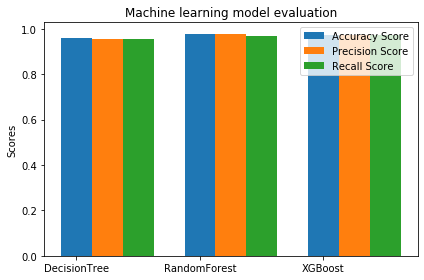

In [26]:
labels = ['DecisionTree', 'RandomForest', 'XGBoost']
accuracy_array = [accuracy_tree, accuracy_rf, accuracy_xgboost]
precision_array = [precision_tree, precision_rf, precision_xgboost]
recall_array = [recall_tree, recall_rf, recall_xgboost]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.00, accuracy_array, width, label='Accuracy Score')
rects2 = ax.bar(x + 0.25, precision_array, width, label='Precision Score')
rects3 = ax.bar(x + 0.50, recall_array, width, label='Recall Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Machine learning model evaluation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

SAVE AND LOAD WITH JOBLIB

In [27]:
joblib.dump(model, "./xgboost.joblib", compress=True)

['./xgboost.joblib']

In [28]:
joblib.dump(tree, "./tree.joblib", compress=True)

['./tree.joblib']

In [29]:
joblib.dump(rf, "./random_forest.joblib", compress=True)

['./random_forest.joblib']

LOAD MODELE TO TEST

In [30]:
model_xgboost = joblib.load("xgboost.joblib")

WE EXPECT THE PREDICTION TO BE ACTIVITY NUMBER 3

In [31]:
df_subject_model.iloc[5000]['activity']

3.0

In [34]:
test1 = pd.DataFrame(df_subject_model.iloc[5000]).T
del test1['activity']
del test1['SKIN']
del test1['Subject']
del test1['ECG_chest']
del test1['Resp_chest']
del test1['BVP_wrist']
test1['ACC_x_chest'] = test1['ACC_x_chest'].astype(str).astype(float)
test1['ACC_y_chest'] = test1['ACC_y_chest'].astype(str).astype(float)
test1['ACC_z_chest'] = test1['ACC_z_chest'].astype(str).astype(float)
test1['ACC_x_wrist'] = test1['ACC_x_wrist'].astype(str).astype(float)
test1['ACC_y_wrist'] = test1['ACC_y_wrist'].astype(str).astype(float)
test1['ACC_z_wrist'] = test1['ACC_z_wrist'].astype(str).astype(float)
test1['TEMP_wrist'] = test1['TEMP_wrist'].astype(str).astype(float)
test1['Gender'] = test1['Gender'].astype(str).astype(int)
test1['AGE'] = test1['AGE'].astype(str).astype(int)
test1['SPORT'] = test1['SPORT'].astype(str).astype(int)
test1['IMC'] = test1['IMC'].astype(str).astype(float)
test1['label'] = test1['label'].astype(str).astype(float)
test1['rpeaks'] = test1['rpeaks'].astype(str).astype(int)

In [35]:
prediction = model_xgboost.predict(test1)

In [36]:
prediction

array([3.])